In [1]:
import pandas as pd 
import seaborn as sbn
import numpy as np
import copy
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics
import statsmodels.api as sm

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

## 1. preprocess des données :

In [2]:
def fix_value(value):
    if isinstance(value, str): 
        return float(value.replace('$', '').replace(',',''))
    else : 
        return value

In [3]:
data = pd.read_csv('auto-insurance-fall-2017/train_auto.csv')
data.drop(columns = ['INDEX'], inplace = True)

data['INCOME'] = data['INCOME'].apply(fix_value)
data['HOME_VAL'] = data['HOME_VAL'].apply(fix_value)
data['BLUEBOOK'] = data['BLUEBOOK'].apply(fix_value)
data['OLDCLAIM'] = data['OLDCLAIM'].apply(fix_value)

data['MSTATUS'] = data['MSTATUS'].map({"z_No":'No', 'Yes':'Yes'})
data['SEX']= data['SEX'].map({"z_F":'F', 'M':'M'})
data['EDUCATION'] = data['EDUCATION'].replace({'z_High School': 'High School'})
data['JOB'] = data['JOB'].replace({'z_Blue Collar': 'Blue Collar'})
data['CAR_TYPE'] = data['CAR_TYPE'].replace({"z_SUV": 'SUV'})
data['URBANICITY'] = data['URBANICITY'].map({'Highly Urban/ Urban':'Urban', 'z_Highly Rural/ Rural':'Rural'})

In [4]:
data.isna().sum()

TARGET_FLAG      0
TARGET_AMT       0
KIDSDRIV         0
AGE              6
HOMEKIDS         0
YOJ            454
INCOME         445
PARENT1          0
HOME_VAL       464
MSTATUS          0
SEX              0
EDUCATION        0
JOB            526
TRAVTIME         0
CAR_USE          0
BLUEBOOK         0
TIF              0
CAR_TYPE         0
RED_CAR          0
OLDCLAIM         0
CLM_FREQ         0
REVOKED          0
MVR_PTS          0
CAR_AGE        510
URBANICITY       0
dtype: int64

- si on supprime les valeurs nan, on perdre approximativement 20% des données.
    - on supprimera au début toutes les lignes avec des valeurs au lieu d'essayer de résoudre ce soucis pour des features qui pourront avoir un effet d'explication nul pour le problème qu'on essaye de tackler.

In [5]:
data = data.dropna()

- On se propose une première subdivision des colonnes en 5 catégories : 

In [6]:
car_specific_cols = ['CAR_USE', 'CAR_TYPE','RED_CAR','CAR_AGE', 'BLUEBOOK', 'MVR_PTS' ]
job_specific_cols = ['JOB', 'YOJ', 'TRAVTIME']
person_specific_cols = ['SEX', 'AGE', 'EDUCATION']
history_specific_cols = ['OLDCLAIM','TIF', 'CLM_FREQ', 'REVOKED']
family_specif_cols = ['MSTATUS', 'PARENT1','KIDSDRIV', 'HOMEKIDS', 'URBANICITY', 'HOME_VAL', 'INCOME']

## 2. Analyse univarié :

le problème qu'on se propose de tackler est de prédire si une personne aura un accident avec sa voiture assurée ou non. Il s'agit donc d'un problème de classification.

+ **Target Flag**

- la variable *Target Flag* est une varibale binaire : une valeur de 0 signifie que la personne en question n'a pas fait d'accident.  

- la figure ci-dessous montre le nombre de lignes dans notre jeu de données par *Target Flag*. On constate que preque 25 % des données correspondent à des target flag à 1 contre 75 % avec target flag à 0.
- le jeux de données n'est donc pas équilibré. ce désequilibre n'est pas si critique pour considérer des méthodes pour la détection d'anomalie. On devrait par contre le prendre en considération lors l'évaluation du modèle par exemple.   

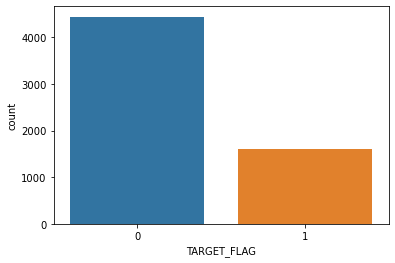

In [7]:
sbn.countplot(x = 'TARGET_FLAG', data =data)

+ **Person specific columns**: 

    - on peut noter à partir des figures ci-dessous : 
        - les hommes et les femmes ont presque le même taux d'accident, les femmes ont par contre un peu plus.
        - le taux d'accident a une tendance décroissante en fonction du niveau des études: 
            ce taux est presque 32% pour les gens qui n'ont pas fait d'études universitaire. 23% pour le diplomés d'un bachelor et presque 16 % pour les gens avec un master /PhD. on peut ainsi garder que 3 catégories: <bachelor, bachelor, >bachelor.
        - le taux d'accident a tendance de diminuer par âge jusqu'au 55 , elle commence ensuite à augmenter. dans un soucis de simplification, on peut se fixer des fourchettes d'âges qui ont un comportement similaire: par exemple : 
        + age <= 25
        + 26 <=age <35
        + 36<= age<45
        + 46 <= age < 55
        + 56<= age<65
        + 66 et plus.  
            

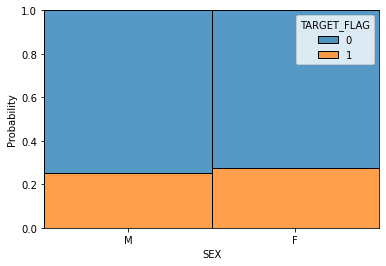

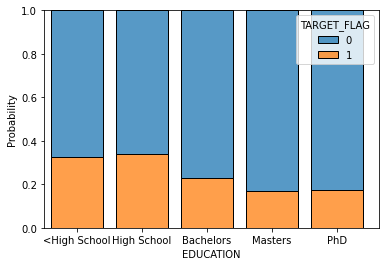

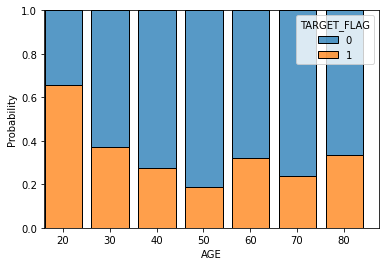

In [8]:
plt.figure()
sbn.histplot(data, x="SEX", hue="TARGET_FLAG", stat="probability", multiple="fill")

plt.figure()
data['EDUCATION'] = pd.Categorical(data['EDUCATION'],\
                                   categories=['<High School', 'High School','Bachelors', 'Masters', 'PhD'],\
                                   ordered=True)
sbn.histplot(data.sort_values(by = 'EDUCATION'), x="EDUCATION", hue="TARGET_FLAG", stat="probability", multiple="fill", shrink=.8,)

plt.figure()
sbn.histplot(data, x="AGE", hue="TARGET_FLAG", stat="probability", multiple="fill", shrink=.8,binwidth = 10)

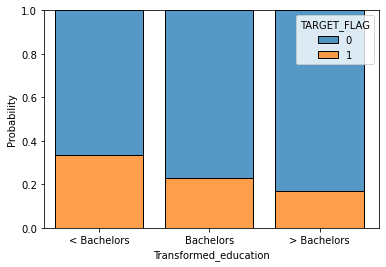

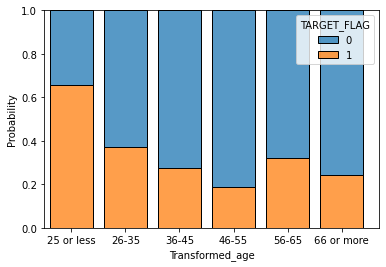

In [9]:
def transform_education(education): 
    if education in {'<High School','High School'}: 
        return '< Bachelors'
    elif education in {'Masters', 'PhD'}: 
        return '> Bachelors'
    else : 
        return education
data['Transformed_education'] = data['EDUCATION'].apply(transform_education)
data['Transformed_education'] = pd.Categorical(data['Transformed_education'],\
                                               categories=['< Bachelors','Bachelors','> Bachelors' ],\
                                               ordered=True)
plt.figure()
sbn.histplot(data.sort_values(by = 'Transformed_education', ), x="Transformed_education",\
             hue="TARGET_FLAG", stat="probability", multiple="fill", shrink=.8,)


def transform_age(age): 
    if age <= 25: 
        return '25 or less'
    elif age <=35:
        return '26-35'
    elif age <= 45:
        return '36-45'
    elif age <= 55:
        return '46-55'
    elif age <= 65:
        return '56-65'
    else: 
        return '66 or more'

data['Transformed_age'] = data['AGE'].apply(transform_age)
plt.figure()
sbn.histplot(data.sort_values(by = 'Transformed_age'), x="Transformed_age",\
             hue="TARGET_FLAG", stat="probability", multiple="fill", shrink=.8)

- **Family specific columns**:

- à partir des figures ci-dessous on peut noter : 
    - les personnes mariées ont un taux d'accident faible par rapport à celui des non mariés. on peut en effet s'attendre à cette conclustion vu que les personnes mariées sont souvent responsables en particulier lors de la conduite de leurs véhicules.
    - les parents célibataires ont un taux d'accident plus grand par rapport aux-  célibataires/parents normaux.(environ le double)
    - le risque d'accident a tendance à augementer avec le nombre d'enfants dans la voiture( sauf dans le cas  des 4 enfants vu que c'est un cas êxtreme et on dispose uniquement de *2 lignes dans notre jeu de donées avec ce nombre*)
    - le taux d'accident est presque constant pour les gens avec un nombre d'enfants supérieur à 1 et relativement faible pour ceux sans enfants
    - le taux d'accident est plus grand en zone urbaine qu'en zone rurale.
    - les gens avec une valeur de 0 pour le "home value" (locataire) on un grand risque , on constate qu'en somme la variable home value est corrélée négativement avec la variable à prédire.(sauf quelques cas êxtremes qu'il faut mieux comprendre à partir des multi-collinéarité entre les variables explicatives)
    - ceci est encore constaté pour la variable "Income".

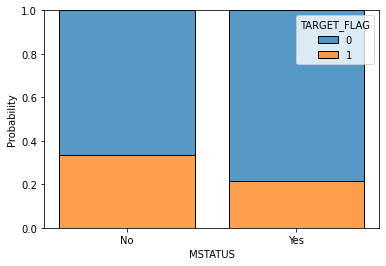

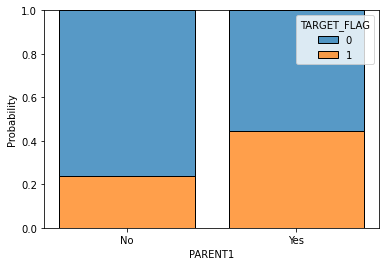

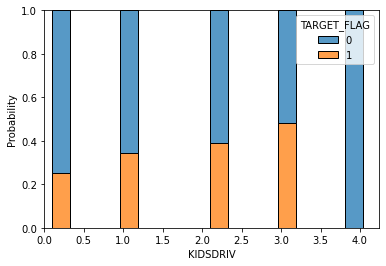

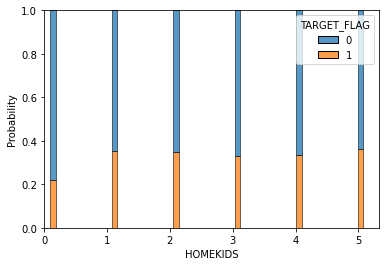

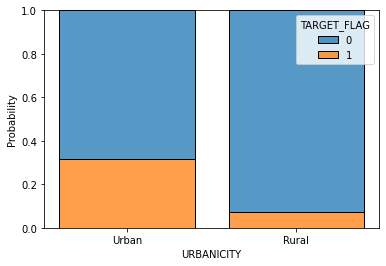

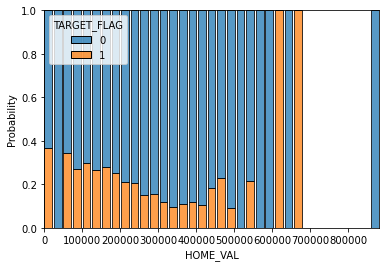

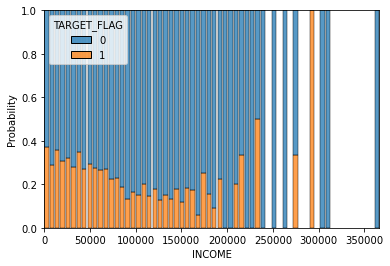

In [10]:
for col in family_specif_cols: 
    plt.figure()
    sbn.histplot(data, x=col, hue="TARGET_FLAG", stat="probability", multiple="fill", shrink=.8)

- **Car specific columns**:

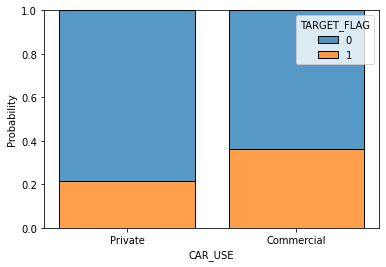

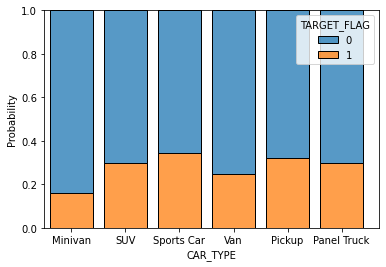

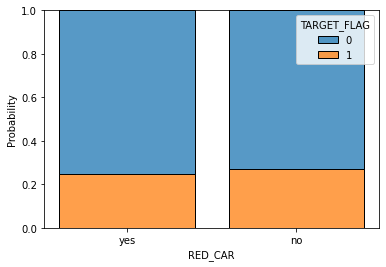

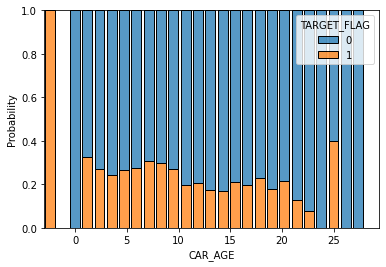

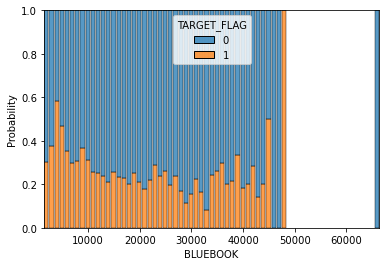

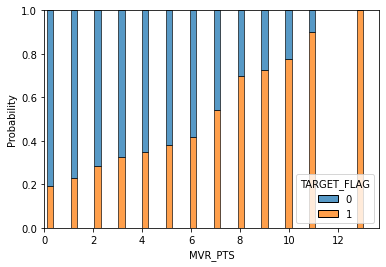

In [11]:
for col in car_specific_cols: 
    plt.figure()
    if col == 'BLUEBOOK': 
        sbn.histplot(data, x=col, hue="TARGET_FLAG", stat="probability", multiple="fill", shrink=.8,binwidth= 1000)
    else : 
        sbn.histplot(data, x=col, hue="TARGET_FLAG", stat="probability", multiple="fill", shrink=.8)

- A partir des figures ci-dessous, on peut constater: 
     - la taux de risque d'accident est plus grand pour les voitures commerciales vu qu'elles roulent plus fréquement que les voitures des particuliers.
     - à priori le fait de savoir si la couleur de la voiture est rouge n'a pas un grand effet sur le taux d'accident.
     - les voitures de type Minivan ont un risque d'accident faible comparé aux autres types comme les voitures de type Pickup et SportsCar.
     - la colonne âge contient des valeur négatives , aprés vérification il s'est avéré qu'il s'agit d'une seule voiture d'âge -3.cette variable n'as pas l'air d'être corrélée avec le risque d'accident (à vérifier numériquement)
     - la variable BlueBook elle aussi ne montre pas une corrélation avec la variable à prédire. elle est possible qu'elle soit utile pour l'estimation de Target_AMT plutôt en cas d'accident.
     - la variabele MVR_PTS a par contre une corrélation positive claire avec le taux d'accident , la relation entre les deux variables peut être approximée par une relation linéaire, une relation linéaire par sous région peut être mieux.

- **job_specific columns**:

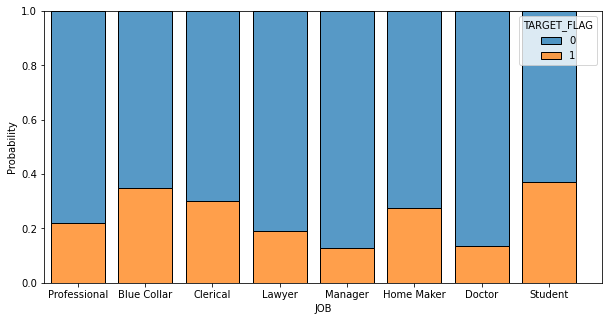

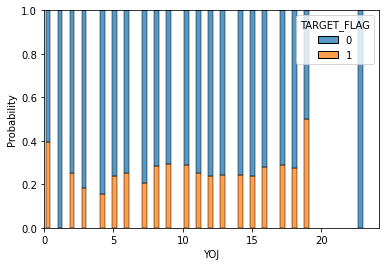

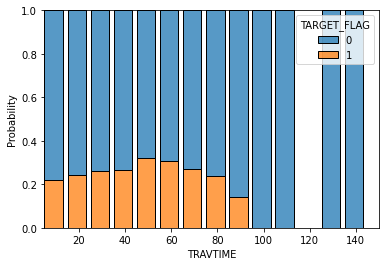

In [12]:
plt.figure(figsize =(10,5))
sbn.histplot(data, x="JOB",hue="TARGET_FLAG", stat="probability", multiple="fill", shrink=.8)

plt.figure()
sbn.histplot(data, x="YOJ", hue="TARGET_FLAG", stat="probability", multiple="fill", shrink=.8)

plt.figure()
sbn.histplot(data, x="TRAVTIME", hue="TARGET_FLAG", stat="probability", multiple="fill", shrink=.8,binwidth= 10 )

- On consate à partir des figures ci-dessus: 
    - le taux de risque est elevé chez les le gens avec un travail *Blue collar* ce qui est attendu vu qu'une majorité de ces travaux requierent l'utilisation de la voiture pendant le travail. le taux d'accident est faible pour les docteurs, les avocats et manger. Il est possible de simpifier cette feature en regroupant dans un classe les travaux qui ont des taux de risque similaires.
    - le risque d'accident est elevé pour les gens pendant leur première année de travail (40%) contre environ (25% ) en moyenne pour le reste.
        - on peut ainsi restreindre cette variable à un variable bianire.
    - en général, il apparait que le TRAVTIME est corrélé positivement avec le taux de d'accident sauf pour les valeurs  supérieur à 70.

- **History Specific columns**: 

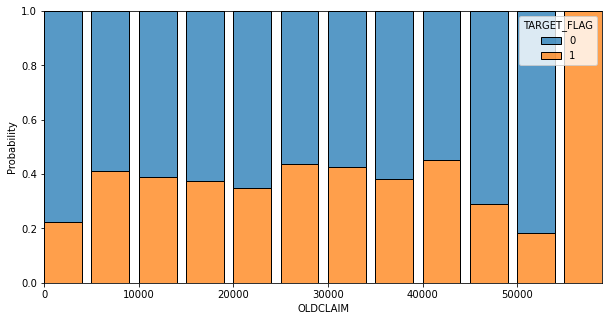

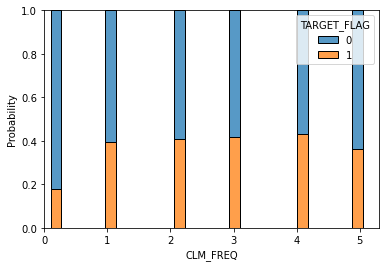

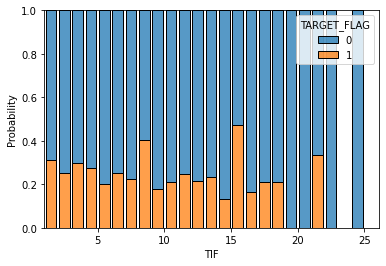

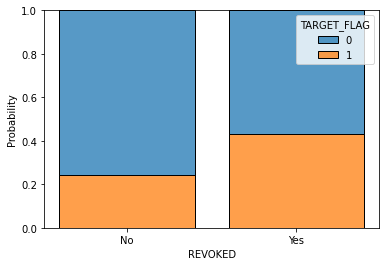

In [13]:
plt.figure(figsize =(10,5))
sbn.histplot(data, x="OLDCLAIM",hue="TARGET_FLAG", stat="probability", multiple="fill", shrink=.8, binwidth= 5000)


plt.figure()
sbn.histplot(data, x="CLM_FREQ", hue="TARGET_FLAG", stat="probability", multiple="fill", shrink=.8)

plt.figure()
sbn.histplot(data, x="TIF", hue="TARGET_FLAG", stat="probability", multiple="fill", shrink=.8, binwidth =1 )

plt.figure()
sbn.histplot(data, x="REVOKED", hue="TARGET_FLAG", stat="probability", multiple="fill", shrink=.8,binwidth= 10 )


- à partir des figures ci-dessus: 
    - sauf quelques cas particuliers, le taux de risque chez des gens qui ont déjâ demandé des remboursements (environ 35% ) est supérieur à celui pour les gens n'ayant jamais demandé ou qui ont demandé une somme inférieure à 5000. 
         - pour les montants grands, on  constate que le taux est presque constant sauf pour des valeurs exrtremes. 
    - le taux de risque est faible pour gens qui n'ont jamais demander de remboursement (20%) contre 40% (pour le reste), 
        - on constate qu'il y a pas une grande différence si une personne a demandé une ou plusieurs fois un remboursemnt . On peut ainsi se restreindre a une variable binaire.
    - le taux de risque est presque de 30% pour des valeurs de TIF faible(inférieure à 5) contre 20% pour le reste.
        - On peut aussi se restreindre à une variable binaire. 
    - les risque d'accident est preque 40% pour des gens avec un permis de conduite déjà révoqué contre 25% pour le reste.

In [14]:
def transfrom_CLM_FRQ(clm_frq): 
    if clm_frq == 0: 
        return 'No'
    else :return 'Yes'
data['Tranformed_clm_freq'] = data['CLM_FREQ'].apply(transfrom_CLM_FRQ)

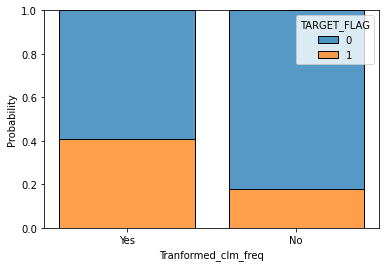

In [15]:
plt.figure()
sbn.histplot(data, x="Tranformed_clm_freq", hue="TARGET_FLAG", stat="probability", multiple="fill", shrink=.8)

In [16]:
def transform_TIF(tif): 
    if tif <= 1: 
        return '1 or less'
    else :return 'more than 1'
data['Tranformed_tif'] = data['TIF'].apply(transform_TIF)

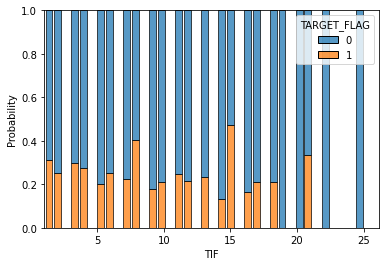

In [17]:
plt.figure()
sbn.histplot(data, x="TIF", hue="TARGET_FLAG", stat="probability", multiple="fill", shrink=.8)

## 3. Analyse Multivarié et Modélisation: 

- on commence dans un premier temps par l'application des transformations déja discutées sur les features .

In [18]:
def preprocess(data, col, action, param): 
    if col in data.columns: 
        if action == 'apply':
            data[col] = data[col].apply(param)
        elif action == 'map': 
            data[col] = data[col].map(param)
        elif action == 'replace':
            data[col] = data[col].replace(param)
        else : 
            raise  f'{action} not supported' 

def transform_TIF(tif): 
    if tif <= 1: 
        return '1 or less'
    else :return 'more than 1'


def transfrom_CLM_FRQ(clm_frq): 
    if clm_frq == 0: 
        return 'No'
    else :return 'Yes'


def transform_age(age): 
    if age <= 25: 
        return '25 or less'
    elif age <=35:
        return '26-35'
    elif age <= 45:
        return '36-45'
    elif age <= 55:
        return '46-55'
    elif age <= 65:
        return '56-65'
    else: 
        return '66 or more'
def transform_education(education): 
    if education in {'<High School','High School'}: 
        return '< Bachelors'
    elif education in {'Masters', 'PhD'}: 
        return '> Bachelors'
    else : 
        return education
    

dict_of_preprocessing = {
    'INCOME': ('apply', fix_value), 
    'HOME_VAL': ('apply', fix_value), 
    'MSTATUS':('map',{"z_No":'No', 'Yes':'Yes'}),
    'SEX': ('replace' , {"z_F":'F'}),
    'EDUCATION': ('replace', {'z_High School': 'High School'}),
    'JOB': ('replace',{'z_Blue Collar': 'Blue Collar'} ),
    'BLUEBOOK': ('apply',fix_value ),
    'CAR_TYPE': ('replace',{"z_SUV": 'SUV'} ),
    'OLDCLAIM':('apply', fix_value),
    'URBANICITY': ('map',{'Highly Urban/ Urban':'Urban', 'z_Highly Rural/ Rural':'Rural'} )
}

dict_of_transformers = {
    'EDUCATION': ('apply',transform_education ),
    'AGE': ('apply', transform_age),
    'CLM_FREQ':('apply', transfrom_CLM_FRQ),
    'TIF': ('apply', transform_TIF)}

final_preprocessing_dict = {
    'MSTATUS':('replace',{'No':0, 'Yes': 1}),
    'SEX': ('replace' , {'F':0, 'M':1}),
    'URBANICITY': ('replace',{'Urban': 1, 'Rural':0} ),
    'CAR_USE':('replace', {'Private': 0, 'Commercial': 1}),
    'PARENT1':('replace', {'No': 0, 'Yes':1}), 
    'RED_CAR':('replace',{"yes": 1, 'no': 0}),
    'REVOKED':('replace', {'Yes':1, 'No':0}),
    'CLM_FREQ': ('replace', {'Yes':1, 'No':0}),
    'TIF': ('replace', {'more than 1' :1 , '1 or less': 0})
}
list_columns_to_dummy = ['EDUCATION', 'AGE', 'JOB', 'CAR_TYPE']
cols_to_delete = ['TARGET_AMT']

def preprocess_data(data_path,
                    dict_of_preprocessing,
                    dict_of_transformers,
                    final_preprocessing_dict,
                    list_columns_to_dummy,
                    cols_to_delete): 
    if isinstance(data_path, str): 
        data = pd.read_csv(data_path)
        data.set_index('INDEX', inplace = True)
    else :
        data = data_path
    
    for col in dict_of_preprocessing: 
        action =dict_of_preprocessing[col][0] 
        param = dict_of_preprocessing[col][1] 
        preprocess(data, col, action, param)
    data.drop(columns = cols_to_delete, inplace = True)
    data = data.dropna()

    for col in dict_of_transformers:
        action = dict_of_transformers[col][0] 
        param = dict_of_transformers[col][1] 
        preprocess(data, col, action, param)


    for col in final_preprocessing_dict:
        action = final_preprocessing_dict[col][0] 
        param =final_preprocessing_dict[col][1] 
        preprocess(data, col, action, param)

    for col in list_columns_to_dummy:
        data = pd.get_dummies(data = data, columns = [col], drop_first= True)
    return data

- on se propose d'utliser un modèle additive generalisé pour réaliser les prédictions souhaitées.
- plus spécifiquement, on applique le modèle de regression logistique qui rélie la probabilité de risque d'accident à une combinaison linéaire des variables explicatives via une *link* fonction qui est la fonction *loigit*
- On garde dans un premier temps toutes la features dont on dispose et on entraine le modèle sur les données d'entrainement qui
represente un proportion de 70% des données.

In [19]:
data_path = 'auto-insurance-fall-2017/train_auto.csv'
data = preprocess_data(data_path,
                       dict_of_preprocessing,
                       dict_of_transformers,
                       final_preprocessing_dict,
                       list_columns_to_dummy,
                       cols_to_delete)
    
X_columns = [col for col in data.columns if col != 'TARGET_FLAG']
X_train, X_test, y_train, y_test = train_test_split(data[X_columns], data['TARGET_FLAG'], test_size=0.3, random_state=0)
X_train = sm.add_constant(X_train)

logit_model = sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.434470
         Iterations 7
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.243      
Dependent Variable:  TARGET_FLAG       AIC:               3754.4852  
Date:                2021-02-01 16:49  BIC:               4002.1428  
No. Observations:    4231              Log-Likelihood:    -1838.2    
Df Model:            38                LL-Null:           -2427.7    
Df Residuals:        4192              LLR p-value:       1.2253e-222
Converged:           1.0000            Scale:             1.0000     
No. Iterations:      7.0000                                          
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
const                 -1.7824   0.4794 -3.7176 0.0002 -2.7221 -0.8427
KIDSDRIV        

- On constate que plusieurs colonnes ont des coefficients non significatives : 
    - ceci peut être dû à des multi-collinearité entre les les colonnes qu'on va minimiser . 
    - la figure ci dessous permet de visualiser les différents corrélation (en valeur absolue) entre les features.

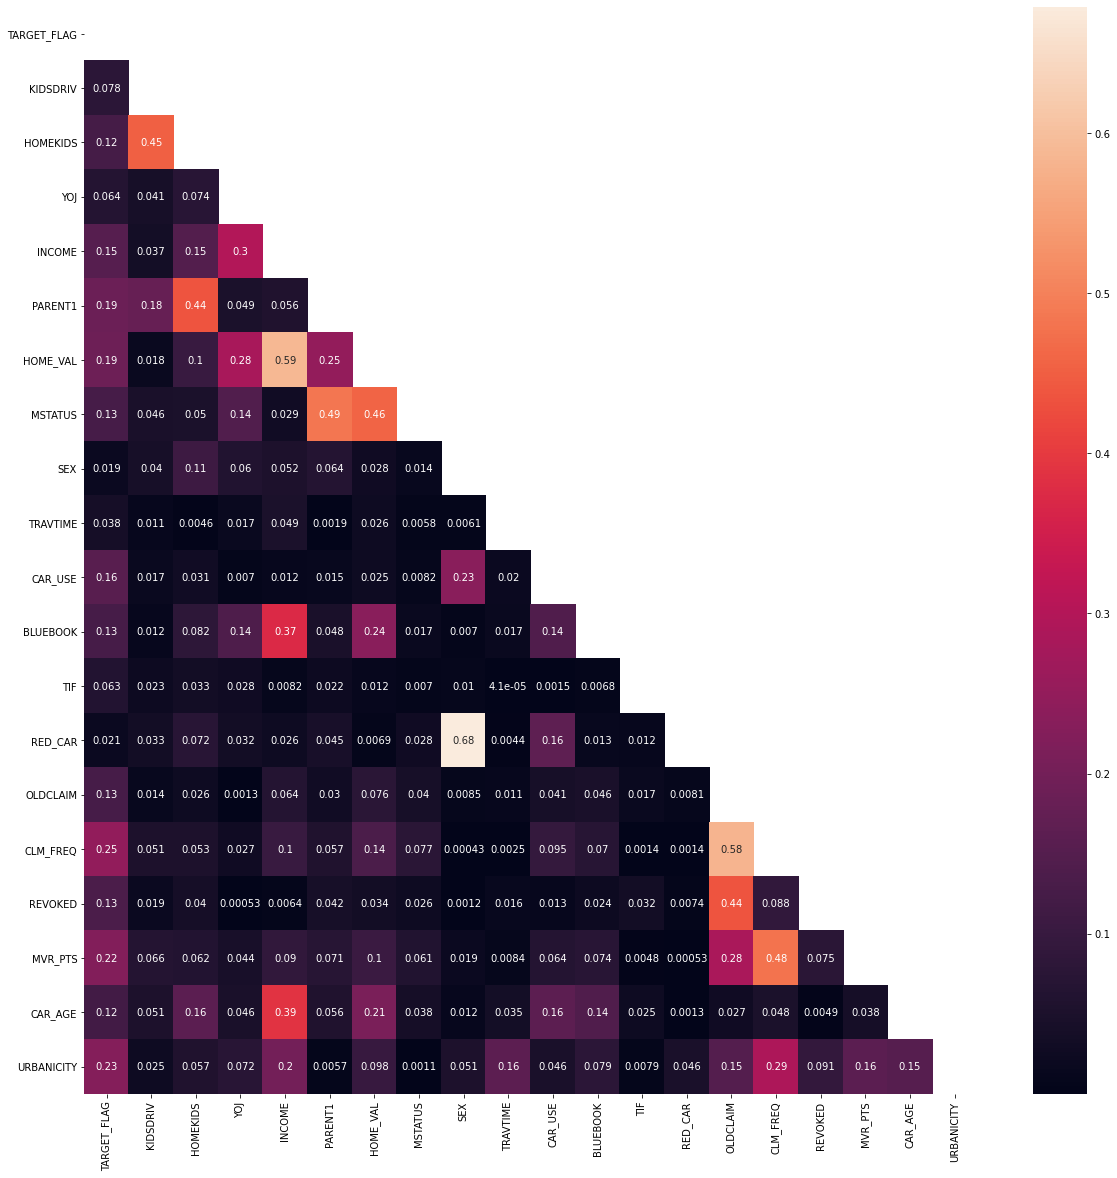

In [20]:
selected_cols = ['TARGET_FLAG'] + ['KIDSDRIV', 'HOMEKIDS', 'YOJ', 'INCOME', 'PARENT1', 'HOME_VAL',\
       'MSTATUS', 'SEX', 'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'RED_CAR',\
       'OLDCLAIM', 'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY']
plt.figure(figsize =(20,20) )
corr_matrix = np.abs(X_train.join(y_train.rename('TARGET_FLAG'))[selected_cols].corr())
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sbn.heatmap(corr_matrix, annot = True, mask= mask)

- les variable qu'on se propose de suprimer sont  : 
    - 'SEX' a une corrélation très faible avec la target FLAG et une  corrélation forte avec la la variable 'RED_CAR' qui elle aussi n'a pas d'effet explicatives.
    - 'CAR_AGE' a une corrélation forte avec plusieurs features importantes , elle a la corrélation minimale avec la *target flag* , on se propose ainsi de la suprimer.
    - 'HOMEKIDS' a une corrélation faible avec la target flag et une corélation forte avec 'kIDSDRIV' et d'autres variables explicatives, on se propose ainsi de supprimer cette variables redondante.
    - 'OLDCLAIM' est fortement corrélée avec 'CLM_FREQ', 'REVOKED', 'MVR_PTS' qui ont une corrélation plus forte avec la variable *Target FlAG*

- vu les coefficients des variables 'INCOME','HOME_VAL' et  'BLUEBOOK' sont assez faibles, on se propose de faire un rescaling en appliquant le logarithme pour réparer les éventuelles asymétries.
- On transforme la variable 'YOJ' en une variable binaire comme expliqué avant. 

In [21]:
cols_to_delete+= ['SEX', 'RED_CAR', 'CAR_AGE', 'HOMEKIDS', 'OLDCLAIM']
dict_of_transformers['YOJ'] = ('apply', lambda x : 1 if x>=1 else 0)
dict_of_transformers['INCOME'] = ('apply', lambda x: np.log(1+x))
dict_of_transformers['HOME_VAL'] = ('apply', lambda x: np.log(1+x))
dict_of_transformers['BLUEBOOK'] = ('apply', lambda x: np.log(1+x))

In [22]:
data = preprocess_data(data_path,
                       dict_of_preprocessing,
                       dict_of_transformers,
                       final_preprocessing_dict,
                       list_columns_to_dummy,
                       cols_to_delete)
    
X_columns = [col for col in data.columns if col != 'TARGET_FLAG']
X_train, X_test, y_train, y_test = train_test_split(data[X_columns], data['TARGET_FLAG'], test_size=0.3, random_state=0)
X_train = sm.add_constant(X_train)

logit_model = sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.431349
         Iterations 7
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.257      
Dependent Variable:  TARGET_FLAG       AIC:               3957.9094  
Date:                2021-02-01 16:49  BIC:               4175.9797  
No. Observations:    4509              Log-Likelihood:    -1945.0    
Df Model:            33                LL-Null:           -2616.5    
Df Residuals:        4475              LLR p-value:       3.0582e-261
Converged:           1.0000            Scale:             1.0000     
No. Iterations:      7.0000                                          
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
const                  0.8179   0.8089  1.0111 0.3120 -0.7675  2.4033
KIDSDRIV        

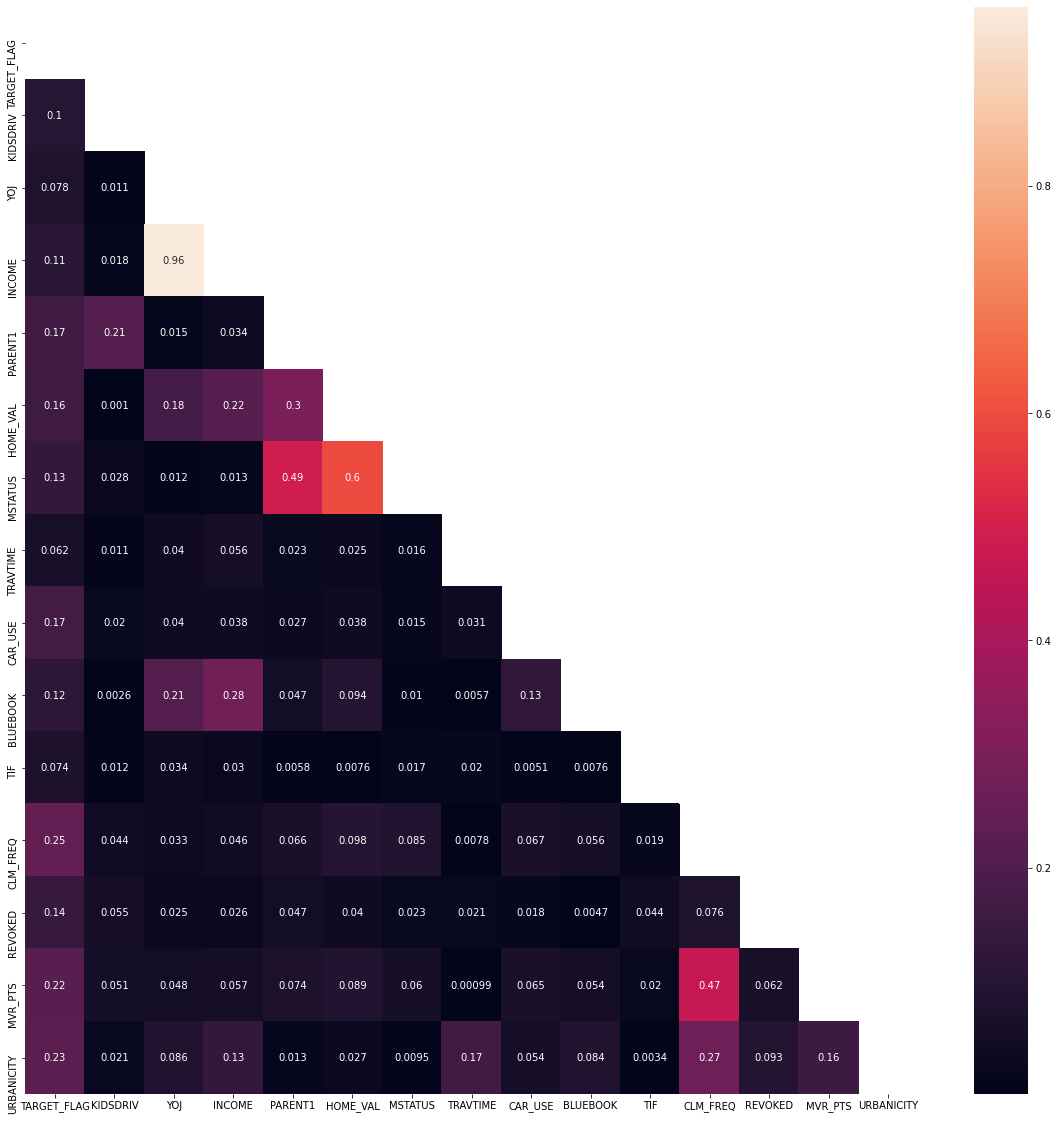

In [23]:
selected_cols = ['TARGET_FLAG'] + [ 'KIDSDRIV', 'YOJ', 'INCOME', 'PARENT1', 'HOME_VAL', 'MSTATUS',
       'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'CLM_FREQ', 'REVOKED',
       'MVR_PTS', 'URBANICITY']
plt.figure(figsize =(20,20) )
corr_matrix = np.abs(X_train.join(y_train.rename('TARGET_FLAG'))[selected_cols].corr())
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sbn.heatmap(corr_matrix, annot = True, mask= mask)

- malgré la transformation proposée sur la variable 'YOJ', elle a encore une faible corrélation avec la 'target flag', on se propose ainsi de la supprimer.
- on se propose aussi de réduire les catégorie pour les variables *transform_JOB*, *transform_age* et *transform_car* en se basant sur l'étude univariée menée ci_dessus.

In [24]:
cols_to_delete+= ['YOJ']
def transform_JOB(job): 
    if job in {'Lawyer', 'Doctor', 'Professional', 'Manager'}: 
        return 0 # Safer_Category
    elif job in {'Clerical', 'Home Maker', 'Student', 'Blue Collar'}: 
        return 1 # 'less_safe_Category'
    else : 
        return job
dict_of_transformers['JOB'] = ('apply', transform_JOB)
list_columns_to_dummy.remove('JOB')

def transform_age(age): 
    if age <= 25: 
        return '25 or less'
    elif age <=35:
        return '26-35'
    elif age <= 45:
        return '36-45'
    elif age <= 55:
        return '46-55'
    else: 
        return '56 or more'
def transform_car(car):
    if car not in {'Minivan', 'Van'}:
        return 'other'# they have more risk
    else : 
        return car
dict_of_transformers['CAR_TYPE'] = ('apply', transform_car)
dict_of_transformers['AGE'] = ('apply', transform_age)  

In [25]:
data = preprocess_data(data_path,
                       dict_of_preprocessing,
                       dict_of_transformers,
                       final_preprocessing_dict,
                       list_columns_to_dummy,
                       cols_to_delete)
    
X_columns = [col for col in data.columns if col != 'TARGET_FLAG']
X_train, X_test, y_train, y_test = train_test_split(data[X_columns], data['TARGET_FLAG'], test_size=0.3, random_state=0)
X_train = sm.add_constant(X_train)

logit_model = sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.446493
         Iterations 7
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.229      
Dependent Variable:  TARGET_FLAG       AIC:               4306.4389  
Date:                2021-02-01 16:49  BIC:               4455.2561  
No. Observations:    4771              Log-Likelihood:    -2130.2    
Df Model:            22                LL-Null:           -2764.5    
Df Residuals:        4748              LLR p-value:       1.0331e-254
Converged:           1.0000            Scale:             1.0000     
No. Iterations:      7.0000                                          
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
const                  1.1917   0.7025  1.6964 0.0898 -0.1852  2.5686
KIDSDRIV        

- On constate finalement que les coefficients de notre modèle sont significatives avec un risque de premier ordre 5 % (toutes les p-values sont inférieurs à 5%)

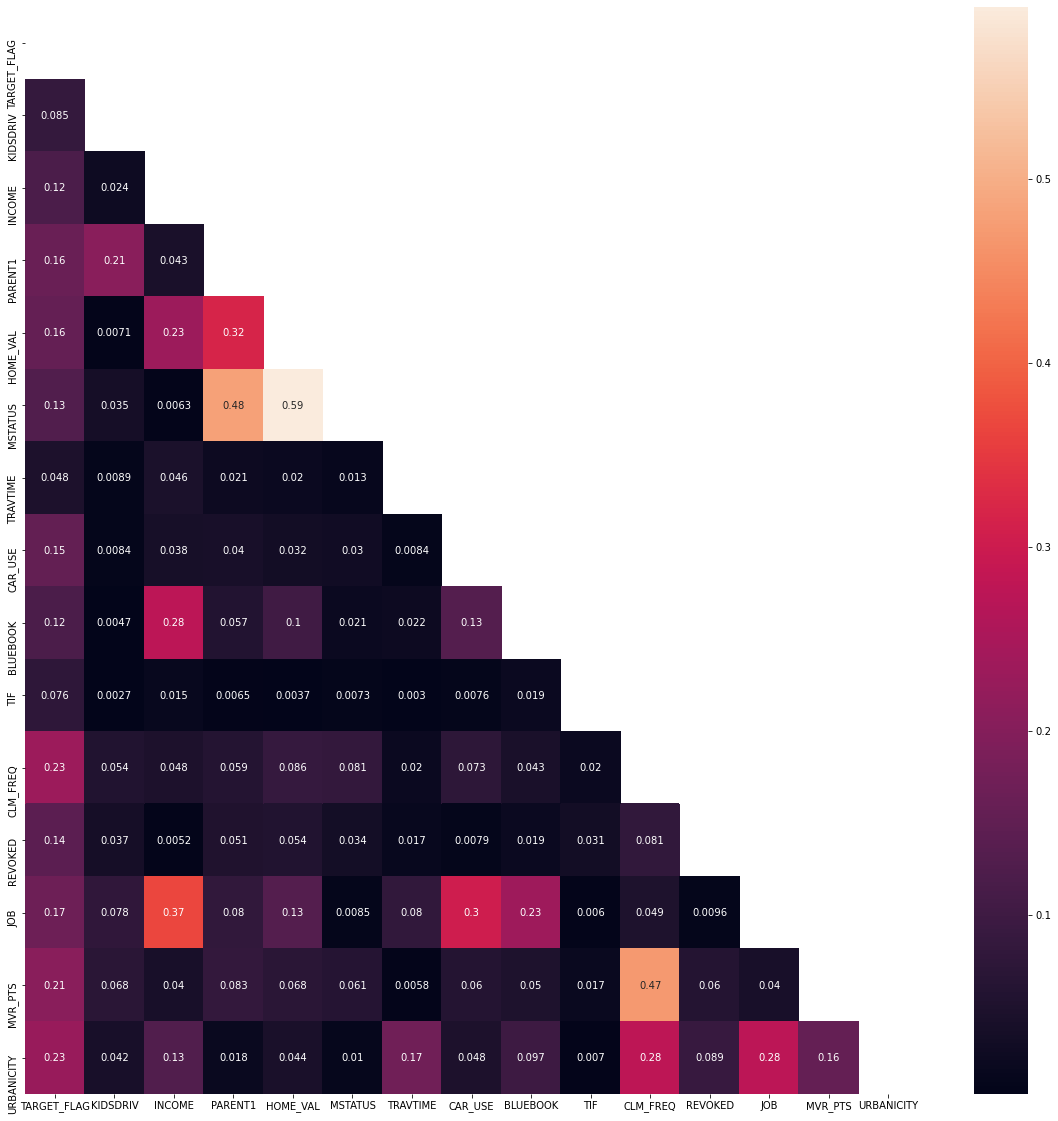

In [26]:
selected_cols = ['TARGET_FLAG'] + [ 'KIDSDRIV', 'INCOME', 'PARENT1', 'HOME_VAL', 'MSTATUS',
       'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'CLM_FREQ', 'REVOKED','JOB',
       'MVR_PTS', 'URBANICITY']
plt.figure(figsize =(20,20) )
corr_matrix = np.abs(X_train.join(y_train.rename('TARGET_FLAG'))[selected_cols].corr())
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sbn.heatmap(corr_matrix, annot = True, mask= mask)

- On applique une MinMaxsclaer pour avoir des coefficients comparatives. 

In [27]:
data = preprocess_data(data_path,
                       dict_of_preprocessing,
                       dict_of_transformers,
                       final_preprocessing_dict,
                       list_columns_to_dummy,
                       cols_to_delete)

    
X_columns = [col for col in data.columns if col != 'TARGET_FLAG']
X_train, X_test, y_train, y_test = train_test_split(data[X_columns], data['TARGET_FLAG'], test_size=0.3, random_state=0)
X_index_train = X_train.index
X_index_test = X_test.index

scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train, columns = X_columns, index =X_index_train )
X_train = sm.add_constant(X_train)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = X_columns, index = X_index_test)


logit_model = sm.Logit(y_train,X_train) 
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.446493
         Iterations 7
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.229      
Dependent Variable:  TARGET_FLAG       AIC:               4306.4389  
Date:                2021-02-01 16:49  BIC:               4455.2561  
No. Observations:    4771              Log-Likelihood:    -2130.2    
Df Model:            22                LL-Null:           -2764.5    
Df Residuals:        4748              LLR p-value:       1.0331e-254
Converged:           1.0000            Scale:             1.0000     
No. Iterations:      7.0000                                          
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
const                 -1.4126   0.4164 -3.3924 0.0007 -2.2288 -0.5965
KIDSDRIV        

- On constate que les coefficients obtenus sont en ligne avec les remarque dans l'analyse univariée : 
   - le risque d'accident est croissant en fonction de fils/filles dans la voiture.
   - le risque d'accident est decroissant  en fonction de l'income.
   - le risque est plus grand pour des personnes avec unn travail *less safe* par exemple *Blue Collar*.
   - le risque diminue avec l'âge et puis rebondit pour des âges plus de 56.
   - le risque diminue avec le niveau de l'éducation.
   - ...

 - **Obtention des Résultats** : 

Accuracy of logistic regression classifier on train set: 0.79
Accuracy of logistic regression classifier on test set: 0.80
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1505
           1       0.66      0.49      0.56       540

    accuracy                           0.80      2045
   macro avg       0.75      0.70      0.72      2045
weighted avg       0.79      0.80      0.79      2045



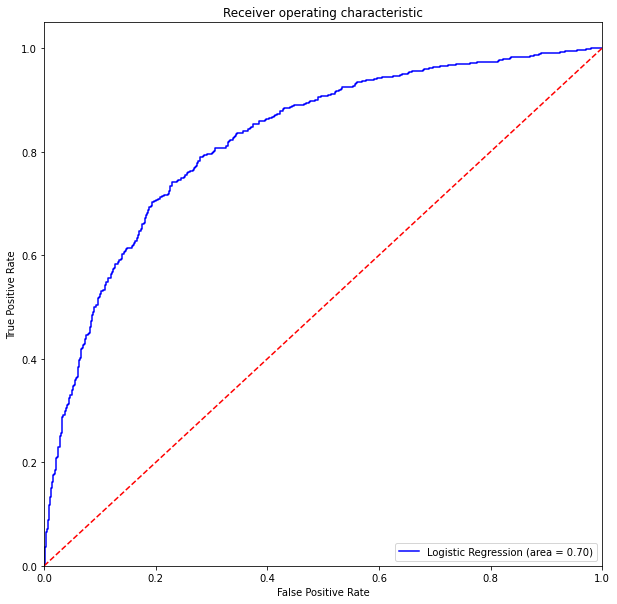

In [28]:
data = preprocess_data(data_path,
                       dict_of_preprocessing,
                       dict_of_transformers,
                       final_preprocessing_dict,
                       list_columns_to_dummy,
                       cols_to_delete)


    
X_columns = [col for col in data.columns if col != 'TARGET_FLAG']
X_train, X_test, y_train, y_test = train_test_split(data[X_columns], data['TARGET_FLAG'], test_size=0.3, random_state=0)

X_index_train = X_train.index
X_index_test = X_test.index

scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train, columns = X_columns, index =X_index_train )
X_train = sm.add_constant(X_train)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = X_columns, index = X_index_test)
X_test = sm.add_constant(X_test)



logreg = LogisticRegressionCV(random_state=0, cv = 5)




logreg.fit(X_train, y_train)

y_pred_train = logreg.predict(X_train)
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(logreg.score(X_train, y_train)))
y_pred_test = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))


print(classification_report(y_test, y_pred_test))


logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure(figsize  =(10,10))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc, color= 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

- le modèle proposé au une performance correcte en fonction d'accuracy. ceci est prédit vu que la donnée est non équilibré.
- le modèle a par contre un faible *RECALL* de 0.49 (classe 1 considerée comme classe positive), le nombre de faux négtives est ainsi grand ce qui montre que le modèle donnes plus d'importance à la classe majoritaire(class 0).
- On cherchera ainsi à maximiser le f1-score qui fait un tradeoff entre la précision et le recall , ainsi que la *AUC* qui vaut 0.7 dans ce cas .

- Un première méthode pour tackler ce déséquilibre consite à le prendre en considération lors de l'entrainement de la fonction de coût. si la classe 0 est 4 plus présente que la classe 1 , elle aura un poids 4 plus petit pour compenser cette équilibre. 

#### Cost-Sensitive Learning : 

Accuracy of logistic regression classifier on train set: 0.73
Accuracy of logistic regression classifier on test set: 0.73
              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1505
           1       0.50      0.79      0.61       540

    accuracy                           0.73      2045
   macro avg       0.70      0.75      0.70      2045
weighted avg       0.80      0.73      0.75      2045



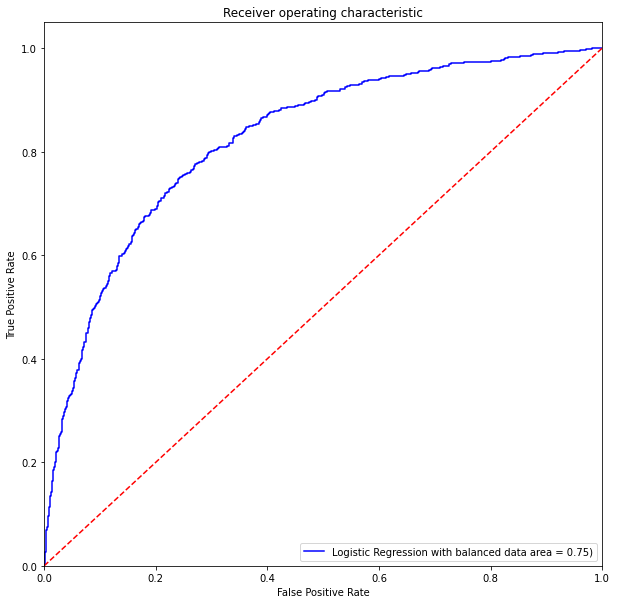

In [29]:
data = preprocess_data(data_path,
                       dict_of_preprocessing,
                       dict_of_transformers,
                       final_preprocessing_dict,
                       list_columns_to_dummy,
                       cols_to_delete)
    
    
X_columns = [col for col in data.columns if col != 'TARGET_FLAG']
X_train, X_test, y_train, y_test = train_test_split(data[X_columns], data['TARGET_FLAG'], test_size=0.3, random_state=0)


X_index_train = X_train.index
X_index_test = X_test.index

balanced_scaler = MinMaxScaler().fit(X_train)
X_train = balanced_scaler.transform(X_train)
X_train = pd.DataFrame(X_train, columns = X_columns, index =X_index_train )
X_train = sm.add_constant(X_train)

X_test = balanced_scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = X_columns, index = X_index_test)
X_test = sm.add_constant(X_test)

balanced_logreg = LogisticRegressionCV(class_weight='balanced',random_state=0, cv = 5)
balanced_logreg.fit(X_train, y_train)

y_pred_train = balanced_logreg.predict(X_train)
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(balanced_logreg.score(X_train, y_train)))
y_pred_test = balanced_logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(balanced_logreg.score(X_test, y_test)))

print(classification_report(y_test, y_pred_test))


logit_roc_auc = roc_auc_score(y_test, balanced_logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, balanced_logreg.predict_proba(X_test)[:,1])
plt.figure(figsize = (10,10))
plt.plot(fpr, tpr, label='Logistic Regression with balanced data area = %0.2f)' % logit_roc_auc, color = 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

- On constate une amélioration du f1-score qui passe de 0.56 à 0.61, la *AUC* elle aussi passe de 0.7 à 0.75
- Une autre méthode d'ajustement consiste à modifier le jeu de données utilisés lors de l'entrainement. on peut ainsi soit effectuer un :
    - Undersampling qui consisite à supprimer des lignes de la classe majoritaire afin d'équilibrer le nombre de points par classes
    - Oversampling qui consiste à amplifier le nombre de lignes de la classe minoritaire qui peut être fait par plusiuers méthodes . On propose ici la méthode  SMOTE qui parcours toutes les observations de la classe minoritaire, cherche ses k plus proches voisins puis synthétise aléatoirement de nouvelles données entre ces k points. une illusration est affichée ci_dessous.

![title](SMOTE.png)

#### Oversampling using SMOTE :

Accuracy of logistic regression classifier on train set: 0.74
Accuracy of logistic regression classifier on test set: 0.74
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1505
           1       0.50      0.79      0.61       540

    accuracy                           0.74      2045
   macro avg       0.70      0.76      0.71      2045
weighted avg       0.80      0.74      0.75      2045



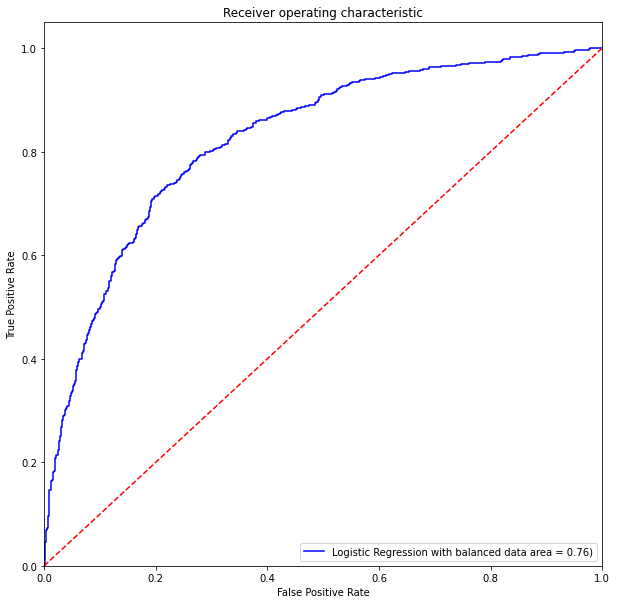

In [30]:
data = preprocess_data(data_path,
                       dict_of_preprocessing,
                       dict_of_transformers,
                       final_preprocessing_dict,
                       list_columns_to_dummy,
                       cols_to_delete)
    
    
X_columns = [col for col in data.columns if col != 'TARGET_FLAG']
X_train, X_test, y_train, y_test = train_test_split(data[X_columns], data['TARGET_FLAG'], test_size=0.3, random_state=0)

X_index_train = X_train.index
X_index_test = X_test.index

smote_scaler = MinMaxScaler().fit(X_train)
X_train = smote_scaler.transform(X_train)
X_train = pd.DataFrame(X_train, columns = X_columns, index =X_index_train )


X_test = smote_scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = X_columns, index = X_index_test)


os = SMOTE(random_state=0, k_neighbors= 6, )

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
X_train = pd.DataFrame(data=os_data_X,columns=X_columns )
y_train= pd.DataFrame(data=os_data_y,columns=['TARGET_FLAG'])['TARGET_FLAG']

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

final_model = LogisticRegressionCV(cv = 5)
final_model.fit(X_train, y_train )

y_pred_train = final_model.predict(X_train)
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(final_model.score(X_train, y_train)))
y_pred_test = final_model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(final_model.score(X_test, y_test)))


print(classification_report(y_test, y_pred_test))


logit_roc_auc = roc_auc_score(y_test, final_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, final_model.predict_proba(X_test)[:,1])
plt.figure(figsize = (10,10))
plt.plot(fpr, tpr, label='Logistic Regression with balanced data area = %0.2f)' % logit_roc_auc, color = 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

On constate une amélioration  marginal par rapport à la méthode cost -sensitive proposée ci-dessus.
   - l'accuracy passe de 73% à 74%
   - le *Recall*, *f1-score* reste presque les mêmes et la *AUC* augmente de 0.01

On passe ensuite à la prédiction sue les données de test.

## 4. Prédiction sur les données de test 

#### lecture des données :

In [31]:
test_data = pd.read_csv('auto-insurance-fall-2017/test_auto.csv')
test_data.set_index('INDEX', inplace= True)

In [32]:
print(f'le nombre de lignes sur le jeu de test est {len(test_data)}')

le nombre de lignes sur le jeu de test est 2141


In [33]:
test_data.isna().sum()

TARGET_FLAG    2141
TARGET_AMT     2141
KIDSDRIV          0
AGE               1
HOMEKIDS          0
YOJ              94
INCOME          125
PARENT1           0
HOME_VAL        111
MSTATUS           0
SEX               0
EDUCATION         0
JOB             139
TRAVTIME          0
CAR_USE           0
BLUEBOOK          0
TIF               0
CAR_TYPE          0
RED_CAR           0
OLDCLAIM          0
CLM_FREQ          0
REVOKED           0
MVR_PTS           0
CAR_AGE         129
URBANICITY        0
dtype: int64

On se concentrera uniquement sur les valeurs *nan* dans les variables utilisés dans la prédiction

In [34]:
test_data[['INCOME', 'HOME_VAL', 'JOB', 'AGE']].isna().sum()

INCOME      125
HOME_VAL    111
JOB         139
AGE           1
dtype: int64

- Age :

        - pour la variable 'AGE' on cherchera uniqument à deviner la fourchette d'âge: 

In [35]:
test_data[test_data.AGE.isna()].T

INDEX,4555
TARGET_FLAG,NaN
TARGET_AMT,NaN
KIDSDRIV,0
AGE,NaN
HOMEKIDS,0
YOJ,9
INCOME,"$14,484"
PARENT1,No
HOME_VAL,$0
MSTATUS,z_No


- la personne en question n'est ni marié ni parent célibataire , elle travaille depuis 9 ans, on peut poser une valuer de *30* pour remplir cette valeur. 

In [36]:
test_data['AGE'].fillna(30, inplace = True)

- Income : 

    - selon l'étude multivariée ci-dessus. nous avions constater une corrélation entre les variables 'BLUEBOOK', 'HOME_VAL', 'URBANICITY'  et 'INCOME'.
    - on propose ansi de prédire les valeurs manquantes de l'INCOME en se basant sur une modèle linéaire.
    - on  propose d'appliquer des transformations logarithmiques sur les variables quantitatives.

In [37]:
test_data_income= test_data[['INCOME', 'BLUEBOOK', 'HOME_VAL', 'URBANICITY']]
for col in dict_of_preprocessing: 
    action =dict_of_preprocessing[col][0] 
    param = dict_of_preprocessing[col][1] 
    preprocess(test_data_income, col, action, param)
test_data_income['URBANICITY'] = test_data_income['URBANICITY'].replace({'Urban': 1, 'Rural':0})

test_data_income = test_data_income[~test_data_income.HOME_VAL.isna()]
test_data_income['HOME_VAL'] = test_data_income['HOME_VAL'].apply(lambda x : np.log(x+1))
test_data_income['BLUEBOOK'] = test_data_income['BLUEBOOK'].apply(lambda x : np.log(x+1))
test_data_income['INCOME'] = test_data_income['INCOME'].apply(lambda x : np.log(x+1))

test_data_income_train = test_data_income[~test_data_income.INCOME.isna()]
test_data_income_test = test_data_income[test_data_income.INCOME.isna()]

income_model = sm.OLS(test_data_income_train[test_data_income_train.columns[0]], test_data_income_train[test_data_income_train.columns[1:]]).fit()

print(income_model.summary())

predicted_log_income = income_model.\
predict(test_data_income_test[test_data_income_train.columns[1:]])
predicted_income = np.exp(predicted_log_income) - 1
predicted_income = predicted_income.apply(lambda x : str(int(x)))

test_data['INCOME'].fillna(predicted_income, inplace= True)

test_data['INCOME'].isna().sum()

                                 OLS Regression Results                                
Dep. Variable:                 INCOME   R-squared (uncentered):                   0.918
Model:                            OLS   Adj. R-squared (uncentered):              0.918
Method:                 Least Squares   F-statistic:                              7122.
Date:                Mon, 01 Feb 2021   Prob (F-statistic):                        0.00
Time:                        16:49:57   Log-Likelihood:                         -4791.4
No. Observations:                1912   AIC:                                      9589.
Df Residuals:                    1909   BIC:                                      9605.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

7

- le modèle entrainé a un $R^2$ ajusté correct de $91.8%$ et des coefficients significatives (p values << 0.005)
- cette approche nous a permis de remplir presque toutes les valeurs de l'income manquantes sauf **7** valeurs vu que pour ces lignes la valeur de *HOME_VAL* est également manqaunte. 

- HOME_VAL:

- selon l'étude multivariée ci-dessus. nous avions constater une corrélation entre les variables 'MSTATUS', 'BLUEBOOK', 'HOMEKIDS' et 'HOME_VAL'.
- on propose ansi de prédire les valeurs manquantes de 'HOME_VAL' la  en se basant sur une modèle linéaire.
- on  propose d'appliquer des transformations logarithmiques sur les variables quantitatives.

In [38]:
test_data_home_val= test_data[['MSTATUS', 'BLUEBOOK', 'HOME_VAL', 'HOMEKIDS']]
for col in dict_of_preprocessing: 
    action =dict_of_preprocessing[col][0] 
    param = dict_of_preprocessing[col][1] 
    preprocess(test_data_home_val, col, action, param)

test_data_home_val['MSTATUS'] = test_data_home_val['MSTATUS'].replace({'No': 0, 'Yes': 1})
test_data_home_val['HOME_VAL'] = test_data_home_val['HOME_VAL'].apply(lambda x : np.log(x+1))
test_data_home_val['BLUEBOOK'] = test_data_home_val['BLUEBOOK'].apply(lambda x : np.log(x+1))


train_cols = [col for col in test_data_home_val if col!='HOME_VAL']
test_data_home_val_train = test_data_home_val[~test_data_home_val.HOME_VAL.isna()]
test_data_home_val_test = test_data_home_val[test_data_home_val.HOME_VAL.isna()]

home_val_model = sm.OLS(test_data_home_val_train['HOME_VAL'],\
                        test_data_home_val_train[train_cols]).fit()

print(home_val_model.summary())


predicted_log_home_val = home_val_model.\
predict(test_data_home_val_test[train_cols])
predicted_home_val = np.exp(predicted_log_home_val) - 1
predicted_home_val = predicted_home_val.apply(lambda x : str(int(x)))

test_data['HOME_VAL'].fillna(predicted_home_val, inplace= True)

test_data['HOME_VAL'].isna().sum()

                                 OLS Regression Results                                
Dep. Variable:               HOME_VAL   R-squared (uncentered):                   0.805
Model:                            OLS   Adj. R-squared (uncentered):              0.805
Method:                 Least Squares   F-statistic:                              2787.
Date:                Mon, 01 Feb 2021   Prob (F-statistic):                        0.00
Time:                        16:49:58   Log-Likelihood:                         -5936.2
No. Observations:                2030   AIC:                                  1.188e+04
Df Residuals:                    2027   BIC:                                  1.190e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

0

- le modèle entrainé a un $R^2$ ajusté correct de $80.5%$ et des coefficients significatives (p values << 0.005)
- cette approche nous a permis de remplir toutes les valeurs de la HOME_VAL manquantes .
- on peut aini prédire l'income pour les 7 lignes qui restent

    + fix the rest of nan income values : 

In [39]:
rest_income_nan_data = test_data[test_data.INCOME.isna()][['BLUEBOOK', 'HOME_VAL', 'URBANICITY']]
for col in dict_of_preprocessing: 
    action =dict_of_preprocessing[col][0] 
    param = dict_of_preprocessing[col][1] 
    preprocess(rest_income_nan_data, col, action, param)
rest_income_nan_data['URBANICITY'] = rest_income_nan_data['URBANICITY'].replace({'Urban': 1, 'Rural':0})
rest_income_nan_data = rest_income_nan_data[~rest_income_nan_data.HOME_VAL.isna()]
rest_income_nan_data['HOME_VAL'] = rest_income_nan_data['HOME_VAL'].apply(lambda x : np.log(x+1))
rest_income_nan_data['BLUEBOOK'] = rest_income_nan_data['BLUEBOOK'].apply(lambda x : np.log(x+1))

test_data['INCOME'].fillna((np.exp(income_model.predict(rest_income_nan_data)) -1).apply(lambda x : str(int(x))),\
                           inplace= True)

- JOB : 

- selon l'étude multivariée ci-dessus. nous avions constater une corrélation entre les variables 'CAR_USE', 'BLUEBOOK', 'INCOME' et 'JOB'.
- on propose ansi de prédire la classe de JOB pour les valeurs manquante de 'JOB'  en se basant sur une modèle de régression logistique.
- on  propose d'appliquer des transformations logarithmiques sur les variables quantitatives.
- si la class prédite est 0 on la map à 'Doctor', sinon on la map à 'Blue Collar', elle sera ensuite reconvertie à 0/1 lors du preprocessing des donées 

In [40]:
test_data_job= test_data[['CAR_USE', 'BLUEBOOK', 'JOB', 'INCOME']]
for col in dict_of_preprocessing: 
    action =dict_of_preprocessing[col][0] 
    param = dict_of_preprocessing[col][1] 
    preprocess(test_data_job, col, action, param)

test_data_job['CAR_USE'] = test_data_job['CAR_USE'].replace({'Private': 0, 'Commercial': 1})
test_data_job['INCOME'] = test_data_job['INCOME'].apply(lambda x : np.log(x+1))
test_data_job['BLUEBOOK'] = test_data_job['BLUEBOOK'].apply(lambda x : np.log(x+1))

train_cols = [col for col in test_data_job if col!='JOB']
test_data_job_train = test_data_job[~test_data_job.JOB.isna()]
test_data_job_train['JOB'] = test_data_job_train['JOB'].apply(transform_JOB)

test_data_job_test = test_data_job[test_data_job.JOB.isna()]

job_model = LogisticRegressionCV(random_state=0, cv = 5)
job_model.fit(test_data_job_train[train_cols], test_data_job_train['JOB'])

y_pred_train = job_model.predict(test_data_job_train[train_cols])
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(job_model.score(test_data_job_train[train_cols], test_data_job_train['JOB'])))

print(classification_report(test_data_job_train['JOB'], y_pred_train))

predicted_job = pd.Series(job_model.predict(test_data_job_test[train_cols]), index = test_data_job_test.index)
predicted_job = predicted_job.map({0 : 'Doctor', 1: 'Blue Collar'})

test_data['JOB'].fillna(predicted_job, inplace = True)

Accuracy of logistic regression classifier on train set: 0.83
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       831
           1       0.84      0.86      0.85      1171

    accuracy                           0.83      2002
   macro avg       0.82      0.82      0.82      2002
weighted avg       0.82      0.83      0.82      2002



- le modèle de régression logistique a un f1-score correct sur le données d'entrainement.
- comme on peut constater ci-dessous on a plus de nan values sur les colonnes qui nous intêressent.

In [41]:
test_data.isna().sum().sort_values()

JOB               0
MVR_PTS           0
REVOKED           0
CLM_FREQ          0
OLDCLAIM          0
RED_CAR           0
CAR_TYPE          0
TIF               0
BLUEBOOK          0
CAR_USE           0
TRAVTIME          0
URBANICITY        0
SEX               0
MSTATUS           0
HOME_VAL          0
PARENT1           0
INCOME            0
HOMEKIDS          0
AGE               0
KIDSDRIV          0
EDUCATION         0
YOJ              94
CAR_AGE         129
TARGET_AMT     2141
TARGET_FLAG    2141
dtype: int64

#### Prédiction sur les données de test avec le cost-sensitive model:

In [42]:
test_data_ = copy.copy(test_data)
test_data_.drop(columns = ['TARGET_FLAG'], inplace = True)

test_data_ = preprocess_data(test_data_,
                       dict_of_preprocessing,
                       dict_of_transformers,
                       final_preprocessing_dict,
                       list_columns_to_dummy,
                       cols_to_delete)

test_data_index = test_data_.index
test_data_columns= test_data_.columns
test_data_ = pd.DataFrame(balanced_scaler.transform(test_data_), index = test_data_index, columns= test_data_columns)

test_data_ = sm.add_constant(test_data_)

balanced_prediction = pd.Series(balanced_logreg.predict(test_data_), index = test_data_.index)
print(balanced_prediction.value_counts())

0    1210
1     931
dtype: int64


#### Prédiction sur les données de test avec le smote_based model:

In [43]:
test_data_ = copy.copy(test_data)
test_data_.drop(columns = ['TARGET_FLAG'], inplace = True)

test_data_ = preprocess_data(test_data_,
                       dict_of_preprocessing,
                       dict_of_transformers,
                       final_preprocessing_dict,
                       list_columns_to_dummy,
                       cols_to_delete)

test_data_index = test_data_.index
test_data_columns= test_data_.columns
test_data_ = pd.DataFrame(smote_scaler.transform(test_data_), index = test_data_index, columns= test_data_columns)

test_data_ = sm.add_constant(test_data_)
smote_prediction = pd.Series(final_model.predict(test_data_), index = test_data_.index)
print(smote_prediction.value_counts())

0    1205
1     936
dtype: int64


- On constate que les deux modèles ont preque le même nombre de prediction par classe.

#### Enregisrement du csv avec les prédictions.

In [44]:
final_prediction = smote_prediction.rename('TARGET_FLAG')
final_prediction.to_csv('target_prediction.csv')

In [45]:
pd.read_csv('target_prediction.csv')

,INDEX,TARGET_FLAG
0,3,0
1,9,1
2,10,0
3,18,0
4,21,1
...,...,...
2136,10279,1
2137,10281,0
2138,10285,0
2139,10294,0
